**Preprocess Data**

Prepare the MNIST data set for training by normalizing the pixel values and reshaping the images to have a single color channel. Normalization helps in faster convergence during training, and reshaping is required because the input layer of your diffusion model expects a three-dimensional tensor. 

In [1]:
import os

# Suppress oneDNN optimizations and lower TensorFlow logging level
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
import numpy as np

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Reshape, Conv2DTranspose

# Load the data set  
(x_train, _), (x_test, _) = mnist.load_data()

# Normalize the pixel values  
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Expand dimensions to match the input shape (28, 28, 1)  
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

# Add noise to the data
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

# Clip the values to be within the range [0, 1]
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

**Build Diffusion Model** 

Build a simple diffusion model with an encoder that compresses the input image into a latent representation and a decoder that reconstructs the image from this representation. The model is compiled with the Adam optimizer and binary cross entropy loss. 

In [3]:
# Define the diffusion model architecture with reduced complexity
input_layer = Input(shape=(28, 28, 1))
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_layer)  # Reduced filters
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)  # Reduced filters
x = Flatten()(x)
x = Dense(64, activation='relu')(x)  # Reduced size
x = Dense(28*28*32, activation='relu')(x)  # Reduced size
x = Reshape((28, 28, 32))(x)
x = Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)  # Reduced filters
x = Conv2DTranspose(16, (3, 3), activation='relu', padding='same')(x)  # Reduced filters
output_layer = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
diffusion_model = Model(input_layer, output_layer)

# Compile the model with mixed precision and a different loss function
diffusion_model.compile(optimizer='adam', loss='mean_squared_error')  # Using MSE for regression tasks

# Summary of the optimized model
diffusion_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        4640      
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 64)                1605696   
                                                                 
 dense_1 (Dense)             (None, 25088)             1630720   
                                                                 
 reshape (Reshape)           (None, 28, 28, 32)        0     

**Add Noise to Data**

In [4]:
# Cache and prefetch the data using TensorFlow data pipelines for faster loading
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_noisy, x_train))
train_dataset = train_dataset.cache().batch(64).prefetch(tf.data.AUTOTUNE)  # Reduced batch size

val_dataset = tf.data.Dataset.from_tensor_slices((x_test_noisy, x_test))
val_dataset = val_dataset.cache().batch(64).prefetch(tf.data.AUTOTUNE)  # Reduced batch size

**Train Diffusion Model**

In [5]:
# Implement early stopping based on validation loss
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Train the model with early stopping and smaller batch size
diffusion_model.fit(
    train_dataset,
    epochs=3,
    shuffle=True,
    validation_data=val_dataset,
    callbacks=[early_stopping]
)

Epoch 1/3
938/938 [==============================] - 100s 106ms/step - loss: 0.0404 - val_loss: 0.0235
Epoch 2/3
938/938 [==============================] - 102s 109ms/step - loss: 0.0203 - val_loss: 0.0198
Epoch 3/3
938/938 [==============================] - 105s 112ms/step - loss: 0.0181 - val_loss: 0.0187


**Evaluate Diffusion Model**

313/313 [==============================] - 4s 14ms/step


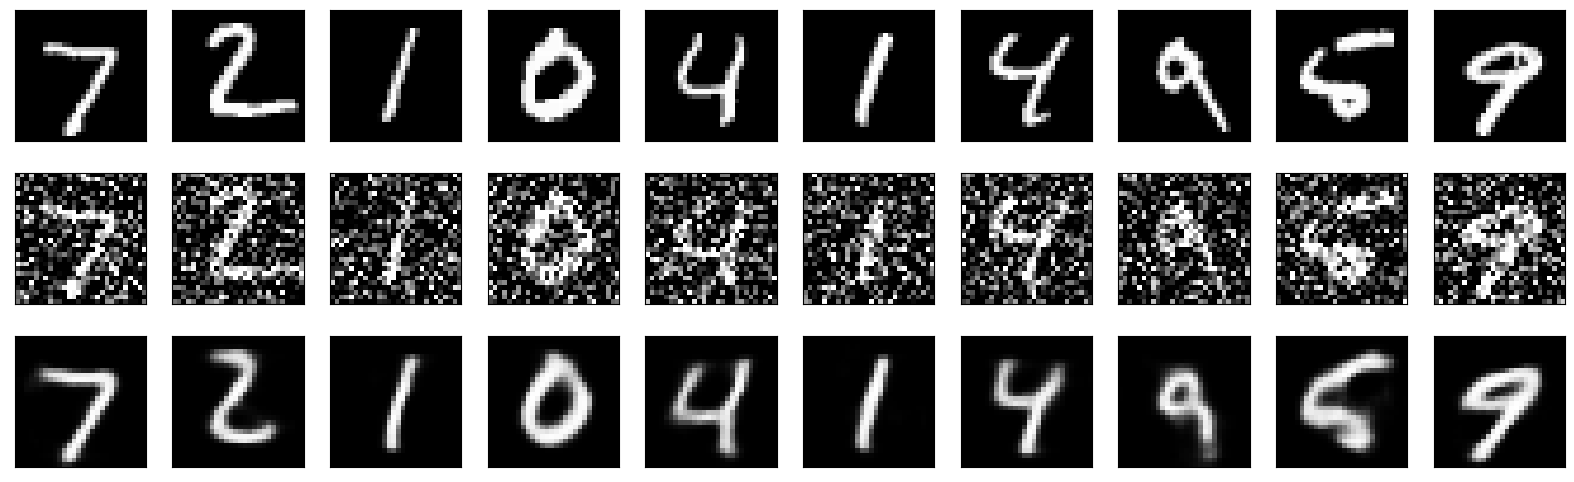

In [6]:
import matplotlib.pyplot as plt

# Predict the denoised images
denoised_images = diffusion_model.predict(x_test_noisy)

# Visualize the results
n = 10  # Number of digits to display
plt.figure(figsize=(20, 6))
for i in range(n):
    # Display original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display noisy
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test_noisy[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display denoised
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(denoised_images[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

**Fine-tune Diffusion Model**

In [7]:
# Unfreeze the top layers of the model
for layer in diffusion_model.layers[-4:]:
    layer.trainable = True

# Compile the model again
diffusion_model.compile(optimizer='adam', loss='binary_crossentropy')

# Train the model again
diffusion_model.fit(x_train_noisy, x_train,
                    epochs=10,
                    batch_size=64,
                    shuffle=True,
                    validation_data=(x_test_noisy, x_test))

Epoch 1/10
938/938 [==============================] - 98s 103ms/step - loss: 0.1136 - val_loss: 0.1119
Epoch 2/10
938/938 [==============================] - 103s 109ms/step - loss: 0.1104 - val_loss: 0.1109
Epoch 3/10
938/938 [==============================] - 100s 107ms/step - loss: 0.1083 - val_loss: 0.1101
Epoch 4/10
938/938 [==============================] - 100s 106ms/step - loss: 0.1065 - val_loss: 0.1102
Epoch 5/10
938/938 [==============================] - 100s 106ms/step - loss: 0.1051 - val_loss: 0.1098
Epoch 6/10
938/938 [==============================] - 101s 107ms/step - loss: 0.1040 - val_loss: 0.1102
Epoch 7/10
938/938 [==============================] - 100s 106ms/step - loss: 0.1030 - val_loss: 0.1100
Epoch 8/10
938/938 [==============================] - 102s 109ms/step - loss: 0.1019 - val_loss: 0.1091
Epoch 9/10
938/938 [==============================] - 98s 105ms/step - loss: 0.1005 - val_loss: 0.1085
Epoch 10/10
938/938 [==============================] - 99s 105ms/s

**Modify Noise Factor**

In [11]:
# Modify the noise factor to 0.3  
noise_factor = 0.3

# Add noise to the data with the new noise factor
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

# Clip the values to be within the range [0, 1]
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

# Retrain the model
diffusion_model.fit(x_train_noisy, x_train, epochs=50, batch_size=128, shuffle=True, validation_data=(x_test_noisy, x_test))

Epoch 1/50
469/469 [==============================] - 76s 162ms/step - loss: 0.0922 - val_loss: 0.0913
Epoch 2/50
469/469 [==============================] - 77s 164ms/step - loss: 0.0906 - val_loss: 0.0909
Epoch 3/50
469/469 [==============================] - 75s 160ms/step - loss: 0.0899 - val_loss: 0.0902
Epoch 4/50
469/469 [==============================] - 74s 158ms/step - loss: 0.0893 - val_loss: 0.0901
Epoch 5/50
469/469 [==============================] - 75s 159ms/step - loss: 0.0888 - val_loss: 0.0897
Epoch 6/50
469/469 [==============================] - 74s 158ms/step - loss: 0.0884 - val_loss: 0.0893
Epoch 7/50
469/469 [==============================] - 74s 159ms/step - loss: 0.0880 - val_loss: 0.0892
Epoch 8/50
469/469 [==============================] - 74s 158ms/step - loss: 0.0876 - val_loss: 0.0890
Epoch 9/50
469/469 [==============================] - 74s 158ms/step - loss: 0.0872 - val_loss: 0.0890
Epoch 10/50
469/469 [==============================] - 74s 157ms/step - l

**Add More Layers to Model**

In [12]:
# Define the modified diffusion model architecture with additional layers
input_layer = Input(shape=(28, 28, 1))

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x) # Additional layer
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dense(28*28*64, activation='relu')(x)
x = Reshape((28, 28, 64))(x)
x = Conv2DTranspose(128, (3, 3), activation='relu', padding='same')(x) # Additional layer
x = Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
x = Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)
output_layer = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

diffusion_model = Model(input_layer, output_layer)

# Compile the model
diffusion_model.compile(optimizer='adam', loss='binary_crossentropy')

# Summary of the model
diffusion_model.summary()

# Train the model
diffusion_model.fit(x_train_noisy, x_train, epochs=50, batch_size=128, shuffle=True, validation_data=(x_test_noisy, x_test))

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 conv2d_4 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 flatten_1 (Flatten)         (None, 100352)            0         
                                                                 
 dense_2 (Dense)             (None, 128)               12845184  
                                                                 
 dense_3 (Dense)             (None, 50176)             6472

**Visualize Effect of Noise**

313/313 [==============================] - 19s 60ms/step


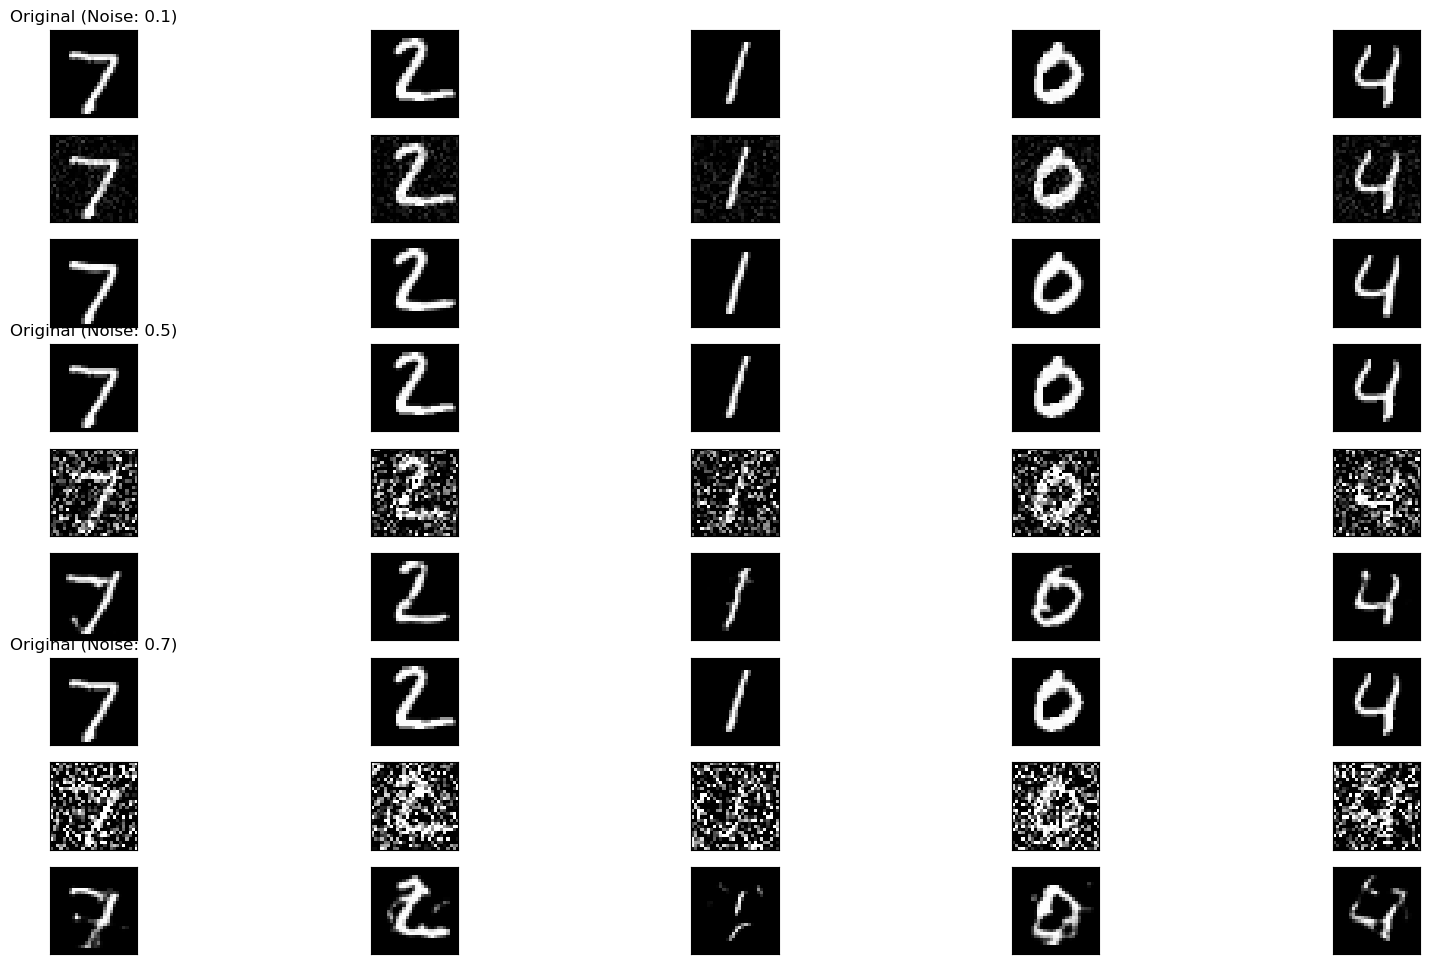

In [22]:
# Function to add noise and predict denoised images
def add_noise_and_predict(noise_factor):
    x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
    x_test_noisy = np.clip(x_test_noisy, 0., 1.)
    denoised_images = diffusion_model.predict(x_test_noisy)
    return x_test_noisy, denoised_images

# Noise levels to test
noise_levels = [0.1, 0.5, 0.7]

# Visualize the results
n=5 # Number of digits to display
plt.figure(figsize=(20, 12))
for idx, noise_factor in enumerate(noise_levels):
    x_test_noisy, denoised_images = add_noise_and_predict(noise_factor)
    
    for i in range(n):
        # Display original
        ax = plt.subplot(3 * len(noise_levels), n, i + 1 + idx * 3 * n)
        plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        if i == 0:
            ax.set_title(f'Original (Noise: {noise_factor})')
        
        # Display noisy
        ax = plt.subplot(3 * len(noise_levels), n, i + 1 + n + idx * 3 * n)
        plt.imshow(x_test_noisy[i].reshape(28, 28), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        # Display denoised
        ax = plt.subplot(3 * len(noise_levels), n, i + 1 + 2 * n + idx * 3 * n)
        plt.imshow(denoised_images[i].reshape(28, 28), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
plt.show()